In [17]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory



In [8]:
classifier_model = load_model('MRI-histopathological-classifier.keras')

2025-10-04 06:46:39.469973: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 06:46:39.483482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 06:46:39.483523: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 06:46:39.486682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 06:46:39.486939: I external/local_xla/xla/stream_executor

In [9]:
MRI_model = load_model('resnet50_cancer_model-MRI-finetuned-version-1.keras')

In [10]:
histopathological_model = load_model('resnet50_cancer_model-finetuned-version-1.keras')

In [31]:
def generate_gradcam(model, img_array, img_path, class_index, class_names, confidence, layer_name='conv5_block3_out'):
    # Create a model that maps input to activations and predictions
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (224, 224))
    original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Superimpose heatmap onto original image
    superimposed_img = cv2.addWeighted(original_rgb, 0.6, heatmap_colored, 0.4, 0)

    # Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM: {class_names[class_index]} (Confidence: {confidence:.2f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [18]:

# Load class names from dataset structure
MRI_class_names = image_dataset_from_directory(
    "./dataset_mri", 
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(224, 224)
).class_names

histo_class_names = image_dataset_from_directory(
    "./dataset",  
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(224, 224)
).class_names


Found 24877 files belonging to 10 classes.
Found 39000 files belonging to 9 classes.


In [19]:
import json

with open("MRI_class_names.json", "w") as f:
    json.dump(MRI_class_names, f)

with open("histo_class_names.json", "w") as f:
    json.dump(histo_class_names, f)


In [20]:
with open("MRI_class_names.json") as f:
    MRI_class_names = json.load(f)

with open("histo_class_names.json") as f:
    histo_class_names = json.load(f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classified as MRI.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


IndexError: invalid index to scalar variable.

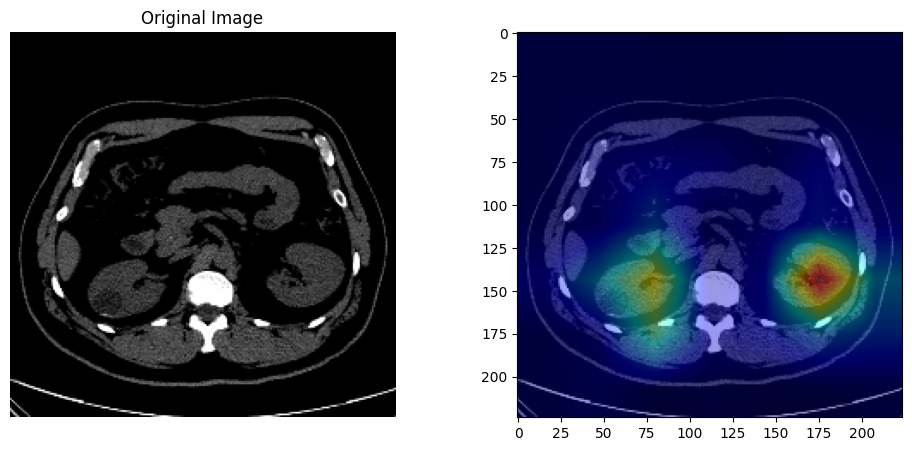

In [30]:
img_path = "./test-image-MRI/4.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)

pred = classifier_model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]
confidence = np.max(pred)

# Route to correct model
if pred_class == 0:  # Assuming 0 = histopathological
    print("Classified as histopathological.")
    result = histopathological_model.predict(img_array)
    result_class = np.argmax(result, axis=1)[0]
    generate_gradcam(histopathological_model, img_array, img_path, result_class, confidence,histo_class_names)
else:
    print("Classified as MRI.")
    result = MRI_model.predict(img_array)
    result_class = np.argmax(result, axis=1)[0]
    generate_gradcam(MRI_model, img_array, img_path, result_class,confidence, MRI_class_names)

